In [53]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dsp import *

In [54]:
def readDat(filepath):
    # 使用16位有符号整数(int16)格式读取原始数据
    y = np.fromfile(filepath, dtype=np.int16)
    # 将整数值归一化到[-1, 1]范围
    y = y.astype(np.float32) / 32768.0
    return y

In [ ]:
# 特征提取
def extractFeature(audio_file, sr=8000, win=256, step=160):
    y = readDat(audio_file)
    
    segments = vad(y, sr, win, step)

    if len(segments) == 0:
        print(f"警告: {audio_file} 没有检测到语音段")
        return None
    
    # 取所有音频段的起始和结束时间
    start = segments[0][0]
    end = segments[-1][1]
    y_speech = y[int(start):int(end)]
    
    # 确保语音段足够长
    min_length = win * 2  # 确保能生成至少一个完整的STFT帧
    if len(y_speech) < min_length:
        print(f"警告: {audio_file} 语音段太短({len(y_speech)}采样点)，填充至{min_length}采样点")
        y_speech = np.pad(y_speech, (0, min_length - len(y_speech)), 'constant')
        # return None


    # 提取 MFCC 特征
    mfcc_feature = computeMFCC(y_speech, sr, win, D=13, M=26)
    return mfcc_feature

In [56]:
# 准备数据集
def prepareData(base_dir, classes):
    features = []
    labels = []

    print(f"开始从 {base_dir} 加载数据...")
    
    total_files = 0         # 总文件数
    error_files = 0         # 出错的文件数
    
    # 先计算总文件数
    for idx, name in enumerate(classes):
        class_dir = os.path.join(base_dir, str(idx).zfill(2))
        if os.path.exists(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.dat'):
                    total_files += 1
    print(f"找到 {total_files} 个文件")
    
    with tqdm(total=total_files, desc="总进度") as pbar:
        for idx, name in enumerate(classes):
            class_dir = os.path.join(base_dir, str(idx).zfill(2))
            
            if not os.path.exists(class_dir):
                print(f"警告：目录 {class_dir} 不存在，跳过类别 '{name}'")
                continue
                
            class_files = [f for f in os.listdir(class_dir) if f.endswith('.dat')]
            print(f"正在处理类别 '{name}' ({len(class_files)}个文件)...")
            
            for filename in class_files:
                filepath = os.path.join(class_dir, filename)
                feature = extractFeature(filepath)
                if feature is not None:
                    features.append(feature)
                    labels.append(idx)
                else:
                    error_files += 1

                pbar.set_postfix({"出错文件数": error_files})
                pbar.update(1)
            
    print(f"\n处理完成: 共 {total_files} 个文件, 出错 {error_files} 个")
    if len(features) == 0:
        raise ValueError("没有成功处理任何文件!请检查数据路径和文件格式")
    
    return features, np.array(labels)

In [57]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import joblib

# HMM 语音识别器
class HMMRecognizer:
    # n_states: 隐藏状态数量
    # n_mix: 每个状态的高斯混合数量
    # cov_type: 协方差类型 ('diag'/'full')
    # n_iter: 训练迭代次数
    def __init__(self, n_state=5, n_mix=8, cov_type='diag', n_iter=100):
        self.n_states = n_state
        self.n_mix = n_mix
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = {}  # 存储每个类别的 HMM 模型
        self.classes = None
        
    def train(self, features, labels):
        self.classes = np.unique(labels)
        
        print(f"开始训练HMM模型, 共{len(self.classes)}个类别...")
        
        for c in tqdm(self.classes):
            # 获取当前类别的所有特征
            class_features = [feat for feat, label in zip(features, labels) if label == c]
            
            if len(class_features) == 0:
                print(f"警告: 类别{c}没有训练样本")
                continue
            
            # 将特征转换为适合HMM训练的格式
            # 1. 首先计算所有样本的总帧数
            total_frames = sum(feat.shape[1] for feat in class_features)
            
            # 2. 创建一个大的连续特征数组
            X = np.zeros((total_frames, class_features[0].shape[0]))
            
            # 3. 填充特征并记录每个样本的长度
            lengths = []
            idx = 0
            for feat in class_features:
                seq_len = feat.shape[1]
                X[idx:idx+seq_len] = feat.T  # 转置以匹配HMM输入要求
                lengths.append(seq_len)
                idx += seq_len
            
            # 初始化并训练HMM模型
            model = hmm.GMMHMM(
                n_components=self.n_states,
                n_mix=self.n_mix,
                covariance_type=self.cov_type,
                n_iter=self.n_iter,
                verbose=False,              # 是否打印训练过程信息
            )
            
            try:
                model.fit(X, lengths)  # 现在X的形状是(总帧数, 特征维度)
                self.models[c] = model
                print(f"类别 {c} 模型训练完成")
            except Exception as e:
                print(f"类别 {c} 模型训练失败: {e}")
    
    # 语音识别
    # feature: MFCC特征，形状为(n_features, n_frames)
    def recognize(self, feature):
        if not self.models:
            raise ValueError("模型尚未训练")
        
        # 计算每个模型的对数似然
        log_likelihoods = {}
        for class_idx, model in self.models.items():
            try:
                # 计算当前特征在该模型下的对数似然
                log_likelihood = model.score(feature.T)
                log_likelihoods[class_idx] = log_likelihood
            except Exception as e:
                print(f"计算类别 {class_idx} 的似然值时出错: {e}")
                log_likelihoods[class_idx] = -np.inf
        
        # 选择对数似然最高的类别
        if not log_likelihoods:
            return None, None
        
        best_class = max(log_likelihoods, key=log_likelihoods.get)
        return best_class, log_likelihoods[best_class]
    
    # 保存模型到文件
    def save(self, filepath):
        joblib.dump({
            'models': self.models,
            'classes': self.classes,
            'n_states': self.n_states,
            'n_mix': self.n_mix,
            'cov_type': self.cov_type
        }, filepath)
        
    def load(self, filepath):
        """加载模型"""
        data = joblib.load(filepath)
        self.models = data['models']
        self.classes = data['classes']
        self.n_states = data['n_states']
        self.n_mix = data['n_mix']
        self.cov_type = data['cov_type']
        
    # 评估模型
    def evaluate(self, features, true_labels):
        predictions = []
        
        print("开始评估模型...")
        for i, feature in enumerate(tqdm(features)):
            pred_class, _ = self.recognize(feature)
            predictions.append(pred_class)
            
        # 计算准确率
        accuracy = accuracy_score(true_labels, predictions)
        print(f"准确率: {accuracy:.4f}")
        
        # 计算混淆矩阵
        cm = confusion_matrix(true_labels, predictions)
        
        # 分类报告
        report = classification_report(true_labels, predictions)
        print("分类报告:")
        print(report)
        
        return accuracy, cm, report

In [58]:
classes = ["数字", "语音", "语言", "处理", "中国", "忠告", "北京", "背景", "上海", "商行",
              "Speech", "Speaker", "Signal", "Sequence", "Processing", "Print", "Project", "File", "Open", "Close"]

# 准备数据集
features, labels = prepareData('../myData', classes)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"训练集: {len(X_train)} 个样本")
print(f"测试集: {len(X_test)} 个样本")

开始从 ../myData 加载数据...
找到 2000 个文件


总进度:   0%|          | 2/2000 [00:00<01:59, 16.68it/s, 出错文件数=0]

正在处理类别 '数字' (100个文件)...


总进度:   5%|▌         | 100/2000 [00:09<01:44, 18.12it/s, 出错文件数=0]

正在处理类别 '语音' (100个文件)...


总进度:  10%|█         | 200/2000 [00:18<02:02, 14.70it/s, 出错文件数=0]

正在处理类别 '语言' (100个文件)...


总进度:  15%|█▌        | 303/2000 [00:28<01:45, 16.07it/s, 出错文件数=0]

正在处理类别 '处理' (100个文件)...


总进度:  20%|██        | 404/2000 [00:37<01:41, 15.79it/s, 出错文件数=0]

正在处理类别 '中国' (100个文件)...


总进度:  25%|██▌       | 504/2000 [00:46<01:39, 15.08it/s, 出错文件数=0]

正在处理类别 '忠告' (100个文件)...


总进度:  30%|███       | 603/2000 [00:55<01:27, 15.95it/s, 出错文件数=0]

正在处理类别 '北京' (100个文件)...


总进度:  35%|███▌      | 703/2000 [01:04<02:02, 10.61it/s, 出错文件数=0]

正在处理类别 '背景' (100个文件)...


总进度:  40%|████      | 803/2000 [01:12<01:13, 16.28it/s, 出错文件数=0]

正在处理类别 '上海' (100个文件)...


总进度:  45%|████▍     | 899/2000 [01:21<02:22,  7.73it/s, 出错文件数=0]

正在处理类别 '商行' (100个文件)...


总进度:  50%|█████     | 1003/2000 [01:31<01:08, 14.59it/s, 出错文件数=0]

正在处理类别 'Speech' (100个文件)...


总进度:  51%|█████▏    | 1026/2000 [01:33<01:12, 13.47it/s, 出错文件数=0]

警告: ../myData/10/22300240004_10_14.dat 语音段太短(480采样点)，填充至512采样点


总进度:  55%|█████▌    | 1103/2000 [01:39<00:48, 18.35it/s, 出错文件数=0]

正在处理类别 'Speaker' (100个文件)...


总进度:  60%|██████    | 1204/2000 [01:47<00:44, 17.78it/s, 出错文件数=0]

正在处理类别 'Signal' (100个文件)...


总进度:  65%|██████▌   | 1303/2000 [01:55<00:42, 16.43it/s, 出错文件数=0]

正在处理类别 'Sequence' (100个文件)...


总进度:  70%|███████   | 1402/2000 [02:03<00:47, 12.48it/s, 出错文件数=0]

正在处理类别 'Processing' (100个文件)...


总进度:  75%|███████▌  | 1500/2000 [02:12<00:29, 17.21it/s, 出错文件数=0]

正在处理类别 'Print' (100个文件)...


总进度:  80%|████████  | 1604/2000 [02:19<00:27, 14.38it/s, 出错文件数=0]

正在处理类别 'Project' (100个文件)...


总进度:  85%|████████▌ | 1705/2000 [02:27<00:14, 19.86it/s, 出错文件数=0]

正在处理类别 'File' (100个文件)...


总进度:  88%|████████▊ | 1763/2000 [02:32<00:22, 10.59it/s, 出错文件数=1]

警告: ../myData/17/23300240026-17-09.dat 没有检测到语音段


总进度:  90%|█████████ | 1801/2000 [02:35<00:08, 23.86it/s, 出错文件数=1]

正在处理类别 'Open' (100个文件)...


总进度:  95%|█████████▌| 1900/2000 [02:42<00:05, 17.82it/s, 出错文件数=1]

正在处理类别 'Close' (100个文件)...


总进度:  95%|█████████▌| 1907/2000 [02:43<00:06, 13.76it/s, 出错文件数=1]

警告: ../myData/19/23300240026-19-07.dat 语音段太短(480采样点)，填充至512采样点


总进度:  98%|█████████▊| 1957/2000 [02:47<00:02, 14.48it/s, 出错文件数=2]

警告: ../myData/19/23300240026-19-13.dat 没有检测到语音段


总进度: 100%|██████████| 2000/2000 [02:50<00:00, 11.71it/s, 出错文件数=2]


处理完成: 共 2000 个文件, 出错 2 个
训练集: 1598 个样本
测试集: 400 个样本


In [59]:
# 训练HMM模型
recognizer = HMMRecognizer(
    n_state=5,  # 隐藏状态数
    n_mix=4,    # 每个状态的高斯混合数
    cov_type='diag', 
    n_iter=150   # 训练迭代次数
)

# 训练模型
recognizer.train(X_train, y_train)

# 保存模型
recognizer.save("hmm/hmm_models.pkl")

# 评估模型
accuracy, cm, report = recognizer.evaluate(X_test, y_test)

开始训练HMM模型, 共20个类别...


  5%|▌         | 1/20 [00:04<01:17,  4.06s/it]

类别 0 模型训练完成


 10%|█         | 2/20 [00:07<01:11,  3.98s/it]

类别 1 模型训练完成


 15%|█▌        | 3/20 [00:14<01:28,  5.22s/it]

类别 2 模型训练完成


 20%|██        | 4/20 [00:18<01:16,  4.81s/it]

类别 3 模型训练完成


 25%|██▌       | 5/20 [00:23<01:11,  4.74s/it]

类别 4 模型训练完成


 30%|███       | 6/20 [00:28<01:06,  4.73s/it]

类别 5 模型训练完成


 35%|███▌      | 7/20 [00:33<01:02,  4.80s/it]

类别 6 模型训练完成


 40%|████      | 8/20 [00:37<00:55,  4.59s/it]

类别 7 模型训练完成


 45%|████▌     | 9/20 [00:41<00:48,  4.44s/it]

类别 8 模型训练完成


 50%|█████     | 10/20 [00:44<00:41,  4.12s/it]

类别 9 模型训练完成


 55%|█████▌    | 11/20 [00:51<00:43,  4.87s/it]

类别 10 模型训练完成


 60%|██████    | 12/20 [00:58<00:44,  5.52s/it]

类别 11 模型训练完成


 65%|██████▌   | 13/20 [01:02<00:35,  5.07s/it]

类别 12 模型训练完成


 70%|███████   | 14/20 [01:06<00:28,  4.82s/it]

类别 13 模型训练完成


 75%|███████▌  | 15/20 [01:10<00:22,  4.49s/it]

类别 14 模型训练完成


 80%|████████  | 16/20 [01:14<00:17,  4.42s/it]

类别 15 模型训练完成


 85%|████████▌ | 17/20 [01:18<00:13,  4.38s/it]

类别 16 模型训练完成


 90%|█████████ | 18/20 [01:24<00:09,  4.67s/it]

类别 17 模型训练完成


 95%|█████████▌| 19/20 [01:31<00:05,  5.51s/it]

类别 18 模型训练完成


100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


类别 19 模型训练完成
开始评估模型...


100%|██████████| 400/400 [00:03<00:00, 105.40it/s]

准确率: 0.8550
分类报告:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      0.90      0.92        20
           2       0.39      0.90      0.55        20
           3       0.94      0.85      0.89        20
           4       1.00      0.75      0.86        20
           5       0.94      0.85      0.89        20
           6       1.00      0.90      0.95        20
           7       0.94      0.80      0.86        20
           8       0.91      1.00      0.95        20
           9       1.00      0.80      0.89        20
          10       1.00      0.75      0.86        20
          11       0.76      0.95      0.84        20
          12       0.90      0.90      0.90        20
          13       1.00      0.75      0.86        20
          14       0.86      0.95      0.90        20
          15       0.64      0.80      0.71        20
          16       0.85      0.85      0.85        20
         

/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 35328 (\N{CJK UNIFIED IDEOGRAPH-8A00}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: Us

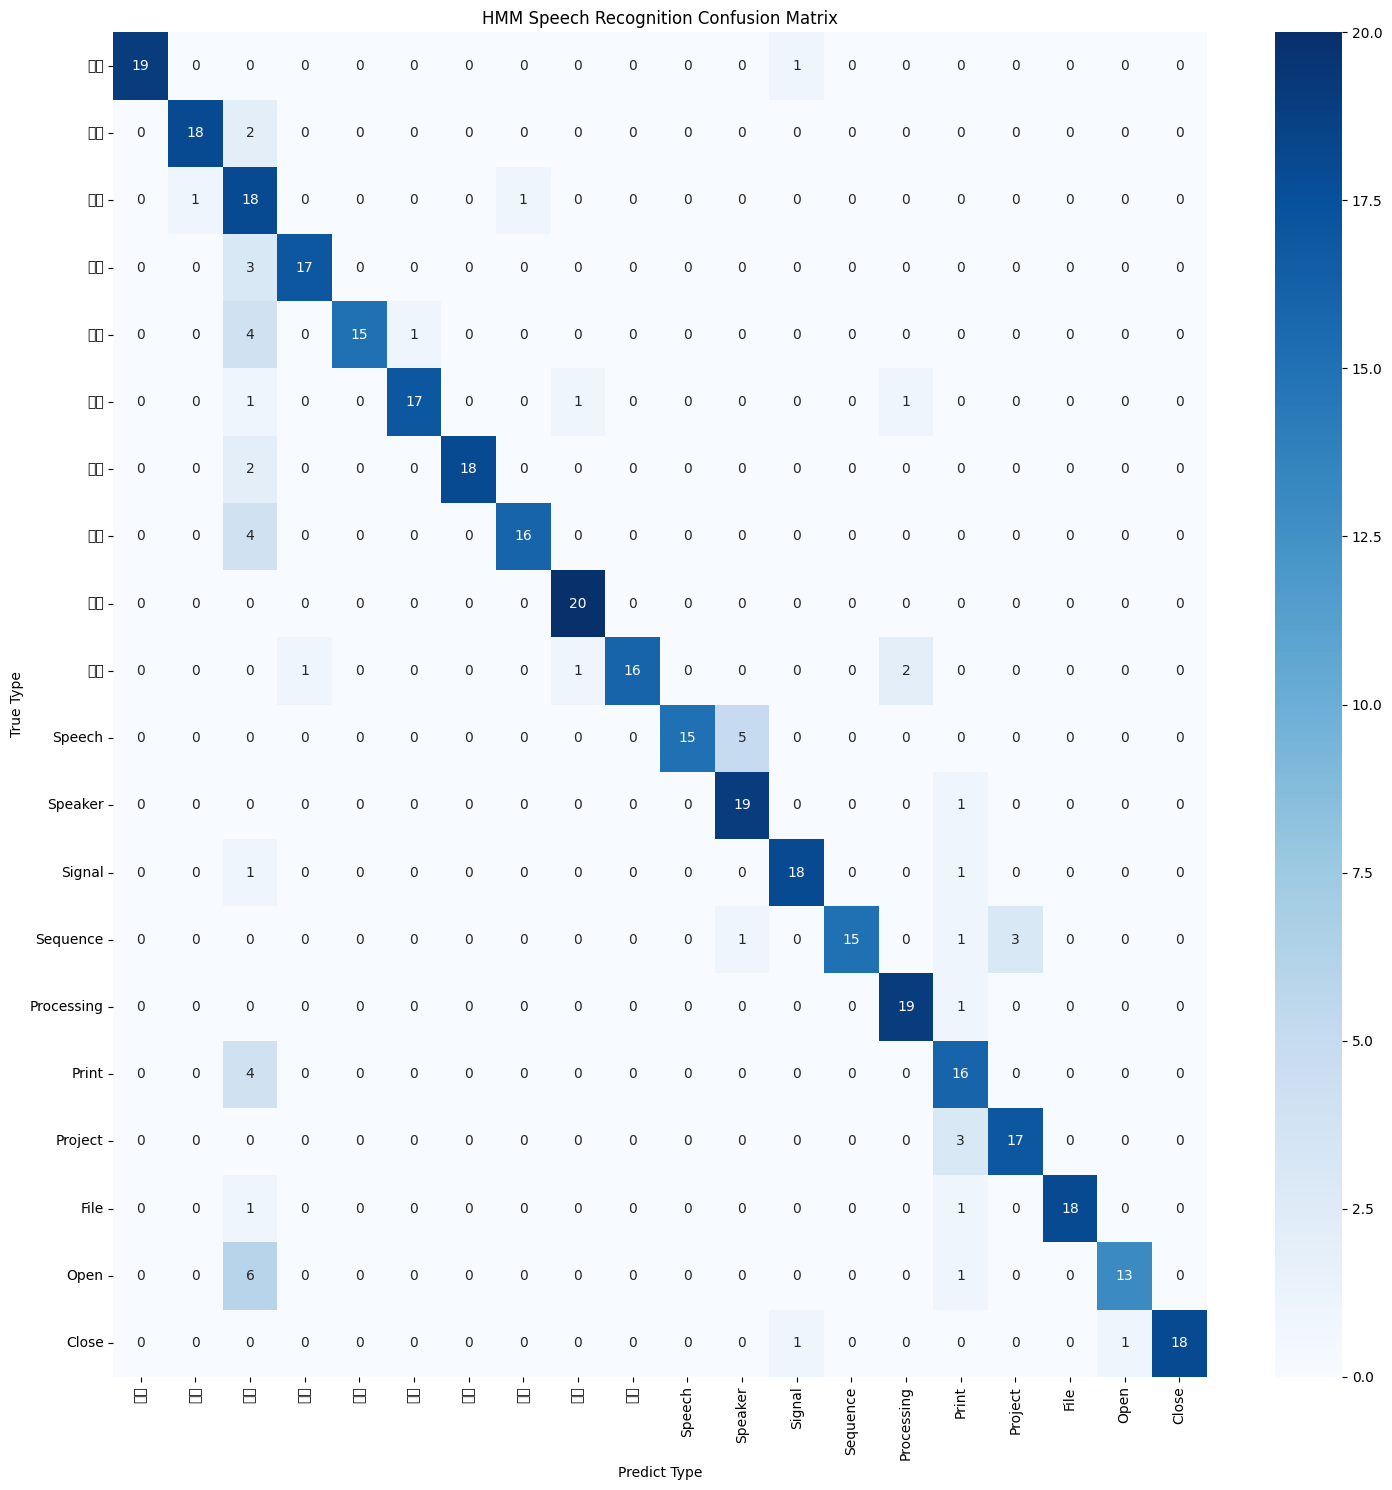

In [60]:
# 绘制混淆矩阵
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predict Type')
plt.ylabel('True Type')
plt.title('HMM Speech Recognition Confusion Matrix')
plt.tight_layout()
plt.show()

In [61]:
# 识别单个语音文件
# audio_file: 语音文件路径
# recognizer: HMM识别器
# class_names: 类别名称列表
def recognize_speech_file(audio_file, recognizer, class_names):
    # 提取特征
    feature = extractFeature(audio_file)
    if feature is None:
        return "无法检测到语音", None
    
    # 使用HMM进行识别
    class_idx, log_likelihood = recognizer.recognize(feature)
    
    if class_idx is None:
        return "识别失败", None
    
    return class_names[class_idx], log_likelihood

In [62]:
# 测试识别
test_file = "../myData/00/22307110206-00-01.dat"    # 测试文件
recognizer.load("hmm/hmm_models.pkl")               # 加载模型
classes = ["数字", "语音", "语言", "处理", "中国", "忠告", "北京", "背景", "上海", "商行",
              "Speech", "Speaker", "Signal", "Sequence", "Processing", "Print", "Project", "File", "Open", "Close"]

pred_class, log_likelihood = recognize_speech_file(test_file, recognizer, classes)
print(f"识别结果: {pred_class}, 对数似然值: {log_likelihood:.2f}")

识别结果: 数字, 对数似然值: -2130.52
